<a href="https://colab.research.google.com/github/melihkurtaran/MachineLearning/blob/main/InstanceBasedLearning/InstancebasedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instance-based Learning Project**

In [5]:
!pip install cvxpy # download cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#Import Libraries
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import cvxpy as cp
from matplotlib import pyplot as plt

In [7]:
#Connect to GitHub for faster access
!git clone https://github.com/melihkurtaran/MachineLearning.git

Cloning into 'MachineLearning'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 84 (delta 40), reused 44 (delta 17), pack-reused 0
Unpacking objects: 100% (84/84), done.


My group number is 9

In [8]:
#Reading the files

#for task 1
ds1 = pd.read_csv('MachineLearning/InstanceBasedLearning/ds091.txt', sep=" ", header=None, index_col=False, skiprows=1)

#for task 2
ds2 = pd.read_csv('MachineLearning/InstanceBasedLearning/ds092.txt', sep=" ", header=None, index_col=False, skiprows=1)

#for task 3
ds3tr = pd.read_csv('MachineLearning/InstanceBasedLearning/ds093tr.txt', sep=" ", header=None, index_col=False, skiprows=1)
ds3te = pd.read_csv('MachineLearning/InstanceBasedLearning/ds093te.txt', sep=" ", header=None, index_col=False, skiprows=1)

# **T1**

## **T1.a**

In [9]:
# Load the training data and labels
X = ds1[[0,1]].values
y = ds1[2].values

In [10]:
X

array([[-2.13173871,  0.6750482 ],
       [-5.65621146, -0.08527528],
       [ 1.35009641,  4.26347742],
       [-3.56711039,  2.06778225],
       [-0.7816423 ,  4.93852562],
       [-4.93852562, -0.7816423 ],
       [-2.15305753,  2.08910107],
       [-3.54579157,  0.65372939],
       [ 0.02131882, -1.41405287],
       [ 1.41405287,  0.02131882],
       [ 2.82810573,  0.04263764],
       [ 4.93852562,  0.7816423 ],
       [ 0.71768584, -0.69636702],
       [ 2.13173871, -0.6750482 ],
       [ 4.2421586 ,  0.06395646],
       [ 4.22083978,  1.47800932]])

In [16]:
class_0 = ds1.loc[ds1[2] == 0]
class_1 = ds1.loc[ds1[2] == 1]


class_0

,0,1,2
0,-2.131739,0.675048,0.0
1,-5.656211,-0.085275,0.0
2,1.350096,4.263477,0.0
3,-3.567110,2.067782,0.0
4,-0.781642,4.938526,0.0
5,-4.938526,-0.781642,0.0
6,-2.153058,2.089101,0.0
7,-3.545792,0.653729,0.0


In [17]:
class_0 = class_0.to_numpy()
class_1 = class_1.to_numpy()

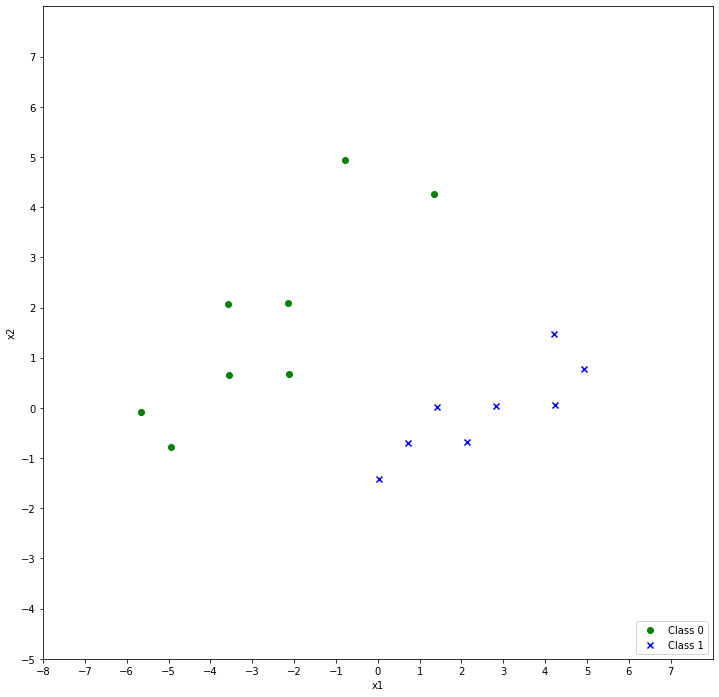

In [30]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='x', color='blue', 
            label='Class 1')

# Set plot limits
plt.xlim(-8, 8)
plt.ylim(-5, 8)

# Set axis ticks
plt.xticks(np.arange(-8, 8, step=1))
plt.yticks(np.arange(-5, 8, step=1))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()
